# Taxi demand prediction in New York City


<img src='New_york.gif'>

In [2]:
'''
Below libraries must be downloaded/installed:
    1. dask
    2. graphviz
    3. toolz
    4. cloudpickle
    5. folium
    6. gpxy
    7. xgboost
    
    download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
    install it in your system and keep the path, migw_path ='installed path'
    mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
#import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocol which makes plots more user intractive like zoom in and zoom out
#matplotlib.use('nbagg')
#from matplotlib import rcParams # Size of plots  

# import dask dataframe
import dask.dataframe as dd # similar to pandas but provides distributed and parallel access

'''
References for Dask:
    1. https://www.youtube.com/watch?v=ieW3G7ZzRZ0 and https://github.com/dask/dask-tutorial
    2. https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
    3. https://www.youtube.com/watch?v=mbfsog3e5DA
'''

import folium # open street map

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
#import gpxpy.geo # Get the haversine distance

# Miscellaneous
import math
import pickle
import warnings
warnings.filterwarnings("ignore")

# Convert to unix time
import datetime
import time
# Reference for unix timestamp => https://www.unixtimestamp.com/

# Models
from sklearn.cluster import MiniBatchKMeans, KMeans # Clustering
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

# Evaluation Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Data Information

<p>
Ge the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (Jan 2015 and Jan 2016 data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) 
</p>

## Information on taxis:
Overview of the Technology Passenger Enhancements Project (T-PEP)

<h5> Yellow Taxi: Yellow Medallion Taxicabs</h5>
<p> These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.</p>

<h5> For Hire Vehicles (FHVs) </h5>
<p> FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged. </p>

<h5> Green Taxi: Street Hail Livery (SHL) </h5>
<p>  The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides. </p>
<p> Credits: Quora</p>

<h5>Footnote:</h5>
In this notebook we are considering only the yellow taxis for the time period Jan 2015 & Jan 2016

# Data Collection
Below are the details yellow taxi trips data from jan-2015 to dec-2016
<table>
<tr>
<th> file name </th>
<th> file name size</th>
<th> number of records </th>
<th> number of features </th>
</tr>
<tr>
<td> yellow_tripdata_2016-01 </td>
<td> 1. 59G </td>
<td> 10906858 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-02 </td>
<td> 1. 66G </td>
<td> 11382049 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-03 </td>
<td> 1. 78G </td>
<td> 12210952 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-04 </td>
<td> 1. 74G </td>
<td> 11934338 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-05 </td>
<td> 1. 73G </td>
<td> 11836853 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-06 </td>
<td> 1. 62G </td>
<td> 11135470 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-07 </td>
<td> 884Mb </td>
<td> 10294080 </td>
<td> 17 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-08 </td>
<td> 854Mb </td>
<td> 9942263 </td>
<td> 17 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-09 </td>
<td> 870Mb </td>
<td> 10116018 </td>
<td> 17 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-10 </td>
<td> 933Mb </td>
<td> 10854626 </td>
<td> 17 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-11 </td>
<td> 868Mb </td>
<td> 10102128 </td>
<td> 17 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-12 </td>
<td> 897Mb </td>
<td> 10449408 </td>
<td> 17 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-01 </td>
<td> 1.84Gb </td>
<td> 12748986 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-02 </td>
<td> 1.81Gb </td>
<td> 12450521 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-03 </td>
<td> 1.94Gb </td>
<td> 13351609 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-04 </td>
<td> 1.90Gb </td>
<td> 13071789 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-05 </td>
<td> 1.91Gb </td>
<td> 13158262 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-06 </td>
<td> 1.79Gb </td>
<td> 12324935 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-07 </td>
<td> 1.68Gb </td>
<td> 11562783 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-08 </td>
<td> 1.62Gb </td>
<td> 11130304 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-09 </td>
<td> 1.63Gb </td>
<td> 11225063 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-10 </td>
<td> 1.79Gb </td>
<td> 12315488 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-11 </td>
<td> 1.65Gb </td>
<td> 11312676 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-12 </td>
<td> 1.67Gb </td>
<td> 11460573 </td>
<td> 19 </td>
</tr>
</table>

In [3]:
# Looking at the features
month = dd.read_csv('C:\\Users\\HARSHALL\\Desktop\\Harshall\\Courses\\Applied AI\\Case Studies\\Taxi Demand Prediction\\Data\\yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [4]:
month.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [12]:
len(month)

12748986

There are about 12.7 million (1 crore and 27 lakh) data points

## Features in the dataset:
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

# ML Problem Formulation
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.</i>
<p> 
To solve the above we would be using data collected in Jan 2015 to predict the pickups in Jan 2016.
</p>

# Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

## EDA and Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

In [5]:
#table below shows few datapoints along with all our features
month.head(10)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   
5         1  2015-01-10 20:33:39   2015-01-10 20:53:52                1   
6         1  2015-01-10 20:33:39   2015-01-10 20:58:31                1   
7         1  2015-01-10 20:33:39   2015-01-10 20:42:20                3   
8         1  2015-01-10 20:33:39   2015-01-10 21:11:35                3   
9         1  2015-01-10 20:33:40   2015-01-10 20:40:44                2   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   
5           9.00        -73.874374        40.774048           1   
6           2.20        -73.983276        40.726009           1   
7           0.80        -74.002663        40.734142           1   
8          18.20        -73.783043        40.644356           2   
9           0.90        -73.985588        40.767948           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   
5                  N         -73.986977         40.758194             1   
6                  N         -73.992470         40.749634             2   
7                  N         -73.995010         40.726326             1   
8                  N         -73.987595         40.759357             2   
9                  N         -73.985916         40.759365             1   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25          0.00   
1         14.5    0.5      0.5        2.00          0.00   
2          9.5    0.5      0.5        0.00          0.00   
3          3.5    0.5      0.5        0.00          0.00   
4         15.0    0.5      0.5        0.00          0.00   
5         27.0    0.5      0.5        6.70          5.33   
6         14.0    0.5      0.5        0.00          0.00   
7          7.0    0.5      0.5        1.66          0.00   
8         52.0    0.0      0.5        0.00          5.33   
9          6.5    0.5      0.5        1.55          0.00   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30  
5                    0.3         40.33  
6                    0.3         15.30  
7                    0.3          9.96  
8                    0.3         58.13  
9                    0.3          9.35

### 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

#### Plotting pickup cordinates which are outside the bounding box of New-York

In [4]:
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]

In [6]:
len(outlier_locations)

247742

There are 247k datapoints which lie outside the bounding box of New York

* **Creating a map with the a base location**
* Read more about the folium here: **http://folium.readthedocs.io/en/latest/quickstart.html**
* **Note:** you dont need to remember any of these, you dont need in depth knowledge on these maps and plots

In [7]:
# Below are the approximate latitude and longitude of Central New York
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 10000 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

<b>Observation:-</b> As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

### 2. Dropoff Latitude & Dropoff Longitude
#### We do the similar analysis for dropoff points

In [8]:
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 10000 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

<b>Observation:-</b> The observations here are similar to those obtained while analysing pickup latitude and longitude

### 3. Trip Durations:

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [64]:
# The timestamps are converted to unix so as to get duration(trip-time) & speed
# Also pickup-times in unix are used while binning

# in our data we have time in the format "YYYY-MM-DD HH:MM:SS"
# we convert this string to python time format and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    # pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    # calculate duration of trips in minutes
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    # append durations of trips and speed in miles/hr to a new dataframe
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup  ## Used for time binning later
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
frame_with_durations = return_with_trip_times(month)

#### Save the dataframe as pickle file for future refrences

In [9]:
frame_with_durations.to_pickle("Save/frame_with_durations")

In [2]:
frame_with_durations = pd.read_pickle("Save/frame_with_durations")

In [15]:
type(frame_with_durations)

pandas.core.frame.DataFrame

### Outlier Detection - "trip_times"

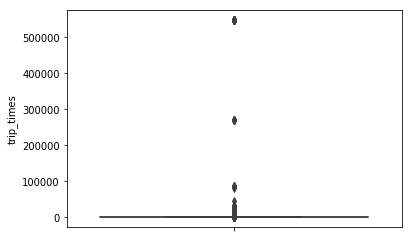

In [17]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data = frame_with_durations)

**Observations:**
* Due to presence of extreme outliers, its difficult to make sense of the box plot
* We can instead try to check percentiles.

Sorting the "trip_times" and calculating percentiles

In [26]:
var = frame_with_durations["trip_times"].values
var = np.sort(var)

In [27]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(i/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.633333


**Observations:**
* There are some trip times which are negative and must be discarded
* On the contrary some trip times are 548555 minutes (i.e. 381 days) which is clearly not in the TLC regulations

In [34]:
# Zooming in from the 90th percecntile to 100
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(i/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.633333


**Removing data based on our analysis and TLC regulations**
* Retaining only positive time_trips and discarding all the negative ones.
* Also retaining only those time trips which are less than 12 hrs (i.e. 720 minutes)

In [36]:
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

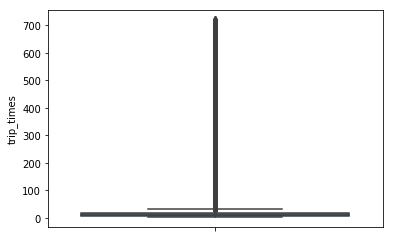

In [37]:
# box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)

**Observations:** Still it seems most of the trip_times are below 50 minutes. But we will stick to this

### 4. Outlier Detection - Speed
**Noe:** Check for any outliers in the data after removing trip duration outliers

Calculate the "Speed" for the modified dataframe again (since trip_time outliers have been removed)

In [38]:
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])

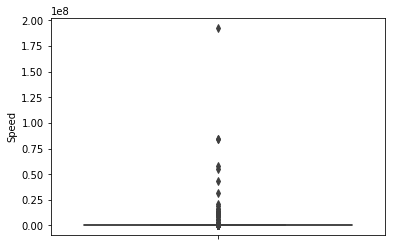

In [39]:
# box-plot for speeds with outliers
sns.boxplot(y="Speed", data =frame_with_durations_modified)

**Observations:**
* Again it is difficult to make sense from the box plot.
* Ths higest value is approximately 2x10^8 miles/hr (which is almost the speed of light :-)
* So we move to percentiles.

In [40]:
# Sort the Speed column
var =frame_with_durations_modified["Speed"].values
var = np.sort(var)

In [41]:
# calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(i/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.857


Zooming in from 90th percentile to 100th

In [42]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(i/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.857


Zooming in still from 99th percentile to 100th

In [43]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.857


Removing further outliers based on the 99.9th percentile value

In [44]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

#### Let's calculate the avg yellow speed of cabs in New-York

In [26]:
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

<b style='font-size:16px'>The avg speed in New York is 12.45 miles/hr, so a cab driver can travel approx <font color='blue'> 2 miles per 10 min on avg.</font> </b>

**This information will be used later**

### 4. Outlier Detection - Trip Distance
* Uptill now we have removed the outliers based on trip durations and cab speeds
* Let's try if there are any outliers in trip distances

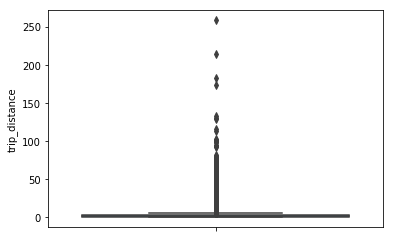

In [45]:
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)

**Observations:**
* The highest value seems to be more than 250 miles (402 km) which is clearly not a local ride in New York.
* Again the box plot is difficult to make sense and hence we move to percentiles.

In [46]:
# Sor the "trip_distance" column
var =frame_with_durations_modified["trip_distance"].values
var = np.sort(var)

In [47]:
# calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(i/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


Zooming in from 90th percentile to 100th

In [48]:
# calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


Zooming in further from 99th percentile to 100th

In [49]:
# calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


#### Removing further outliers based on the 99.9th percentile value

In [50]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

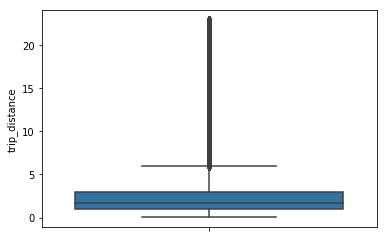

In [51]:
# box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

At least it is readable and we will stick to it

### 5. Outlier Detection - Total Fare
* Uptill now we have removed the outliers based on trip durations, cab speeds, and trip distances
* Let's try if there are any outliers in based on the total_amount

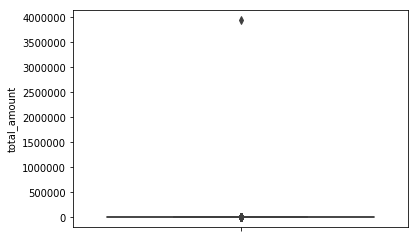

In [52]:
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data = frame_with_durations_modified)

**Observations:**
* The highest fare amount is approximately /$4million ;-P
* So we move to percentiles again.

In [53]:
## Sort the total_amount column
var = frame_with_durations_modified["total_amount"].values
var = np.sort(var)

In [54]:
# calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(i/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


**Observations:** There are some negative fare amounts and some really huge amounts which both must be discarded

Zooming i from 90th percentile to 100th percentile

In [55]:
# calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(i/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


Zooming in further from 99th percentile to 100th

In [56]:
# calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


<b>Observation:-</b> As even the 99.9th percentile value doesnt look like an outlier, as there is not much difference between the 99.8th percentile and 99.9th percentile, let's do some more graphical analyis.

Below plot shows us the last few fare values(sorted) to find a sharp increase to remove those values as outliers

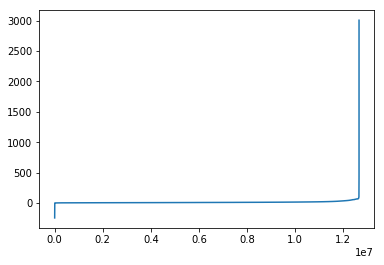

In [57]:
# plot the fare amount only for the last two highest values
plt.plot(var[:-2])
plt.show()

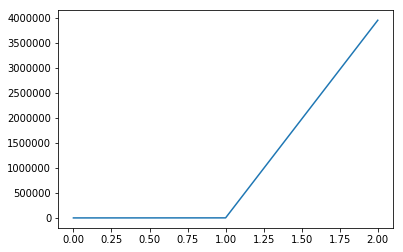

In [58]:
# plotting last three total fare values
plt.plot(var[-3:])
plt.show()

A very sharp increase in fare values can be seen at the second last value

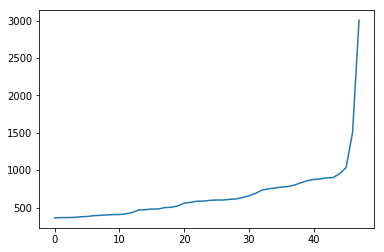

In [59]:
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

**Obsrvations:**
* Now looking at values not including the last two points we again find a drastic increase at around 1000 fare value.
* So we remove all the data points whose far value is greater that 1000 dollars (and less than 0).

In [60]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.total_amount>0) & (frame_with_durations.total_amount<1000)]

Calculate the percentage of data points left after removing all the erroneous/ outlierss data points

## Remove all outliers/erronous points.

In [3]:
# removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [4]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


Delete the dataframe "frame_with_durations" from the main memory by uncommenting and executing the below cell. This helps to keep only relevant data structures in the memorythus avoid unnecessary load on RAM.

In [5]:
# del frame_with_durations

# Data-preperation
## Clustering/Segmentation

In [7]:
# Create a dataset containing only pickup_latitude and pickup_longitude of all the data points
# This will be used to find clusters (regions) in the New York city
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
coords[:10,:]

array([[ 40.75011063, -73.99389648],
       [ 40.72424316, -74.00164795],
       [ 40.80278778, -73.96334076],
       [ 40.7138176 , -74.00908661],
       [ 40.76242828, -73.97117615],
       [ 40.77404785, -73.87437439],
       [ 40.72600937, -73.98327637],
       [ 40.7341423 , -74.00266266],
       [ 40.64435577, -73.78304291],
       [ 40.76794815, -73.98558807]])

**Explanation of Haversine distance**
* Lets you have two locations A and B
* Let latitude and longitude of location A be latA and lonA respectively
* Let latitude and longitude of location B be latB and lonB respectively
* Then the haversine distance is defined as follows:

K = haversine_distance(latA, lonA, latB, lonB)

where the returned value 'K' is the distance between location A and location B in meters

Reference for MiniBatchKMeans => http://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans

In [20]:
# trying different cluster sizes to choose the right K in K-means

def find_min_distance(cluster_centers, cluster_len):
    less2 = [] # less2[i] => No. of clusters within the vicinity of 2 miles from cluster i 
    more2 = [] # more2[i] => No. of clusters outside the vicinity of 2 miles from cluster i
    
    min_dist=1000  ## Randomly initialize high value (like infinity)
    
    for i in range(0, cluster_len):  ## i iterates for each cluster
        nice_points = 0
        wrong_points = 0
        
        for j in range(0, cluster_len): ## j iterates for each cluster
            if j!=i:  ## For two separate clusters
                ## distance between cluster centers of clusters i and j (inter cluster distance)
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                
                ## distance is calculaed in meters and is converted to miles below
                min_dist = min(min_dist,distance/(1.60934*1000))  ## 1 mile = 1.60934 km
                
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        
        less2.append(nice_points)
        more2.append(wrong_points)
    
    print ("On choosing a cluster size of ",cluster_len,
           "\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", \
           np.round(sum(less2)/len(less2), 2), "\nAvg. Number of Clusters outside the vicinity \
           (i.e. intercluster-distance > 2):", np.round(sum(more2)/len(more2), 2),\
           "\nMin inter-cluster distance = ",\
           min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42)
    kmeans.fit(coords)
    cluster_centers = kmeans.cluster_centers_  ## Coordinates of cluster centers
    cluster_len = len(cluster_centers)  ## No. of clusters => n_clusters
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
# that are close to any cluster center
# and make sure that the minimum inter cluster distance should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 1.8 
Avg. Number of Clusters outside the vicinity            (i.e. intercluster-distance > 2): 7.2 
Min inter-cluster distance =  1.0933194607372518 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 3.2 
Avg. Number of Clusters outside the vicinity            (i.e. intercluster-distance > 2): 15.8 
Min inter-cluster distance =  0.7123318236197774 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.13 
Avg. Number of Clusters outside the vicinity            (i.e. intercluster-distance > 2): 21.87 
Min inter-cluster distance =  0.5179286172497254 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.05 
Avg. Number of Clusters outside the vicinity            (i.e. intercluster-d

### Inference:
- The main objective was to find an optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters.
- A hueristic for min distance between any two clusters is set as 0.5 miles
- This is achieved when no. of clusters is 40
- If check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other, which makes the cluster size too small
- So we choose 40 clusters to solve the problem further
- **Note:** This is just a matter of choice which depends on the individual solving the problem. In case to have more precise rules, we can consult domain experts.

In [27]:
# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0)
kmeans.fit(coords)
# Predict the closest cluster each sample in dataset belongs to.
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

In [28]:
frame_with_durations_outliers_removed['pickup_cluster'].head(10)

0    34
1     2
2    16
3    38
4    22
5     3
6    36
7     2
8     5
9    26
Name: pickup_cluster, dtype: int32

In [32]:
frame_with_durations_outliers_removed.pickup_longitude[:10]

0   -73.993896
1   -74.001648
2   -73.963341
3   -74.009087
4   -73.971176
5   -73.874374
6   -73.983276
7   -74.002663
8   -73.783043
9   -73.985588
Name: pickup_longitude, dtype: float64

### Plotting the cluster centers:

In [29]:
# Plotting the cluster centers on OSM
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:

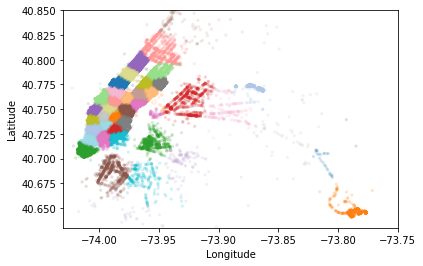

In [34]:
# Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)  # X-axis limits
    city_lat_border = (40.63, 40.85)  # Y-axis limits
    fig, ax = plt.subplots(ncols=1, nrows=1)
    
    # Create a scatter plot of first 100000 data points with longitude on x-axis and latitude on y-axis
    # Parameter 'c' => Points belonging to the same cluster must have the same color
    # Parameter 'lw' => lw=0 means linewidth is 0.
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## Time-binning
* Since we want to predict the no. of pickups at a given timestamp, we divide the time into bins(intervals) of 10 minutes and allocate each pickup to  particular bin.
* Note: Selecting the size of the bin (10 mins) depends on the individual and is not a rule
* Currently we have the data for the month of Jan-2015, so by using the unix timestamp we will divide the time.
* No. of minutes in the month of Jan = 24\*60\*31 = 44640 (since we have 31 days in Jan)
* So if we divide the time into 10 min intervals, we will have 44640/10 = **4464* bins (for the month on Jan 2015 only)

Get the unix timestamps of all the pickups

In [45]:
unix_pickup_times=[i for i in frame_with_durations_outliers_removed['pickup_times'].values]
unix_pickup_times[:5]

[1421328939.0, 1420902218.0, 1420902218.0, 1420902219.0, 1420902219.0]

### Binning procedure
* Refer https://www.unixtimestamp.com/ to get the unix timestamp of 01 Jan 2015 (00:00:00).
* It is **1420070400**
* The idea is: First 10 minutes from 1420070400 fall in bin 1, second 10 minutes from 1420070400 fall in bin 2 and so on..
* So we first subtract 1420070400 from every timestamp of the dataset.
* **Note:** Since the timestamps are in seconds, we also divide each value by 600 (60*10), so that each entry then belongs to a particular 10 minute bin

In [46]:
tenminutewise_binned_unix_pickup_times = [int((i-1420070400)/600) for i in unix_pickup_times]

Ideally all the values must lie from 0 to 4463, let's check if it is the case:

In [48]:
print("Min = {}, Max = {}".format(min(tenminutewise_binned_unix_pickup_times), max(tenminutewise_binned_unix_pickup_times)))

Min = -33, Max = 4430


The minimum bin is -33 and not 0. What can be the reason?

**Notice** that the unix timestamp we got from https://www.unixtimestamp.com/index.php assumes the input time in UTC/GMT (Greenwich Mean Time). However New York falls under EST (Eastern Standard Time).

So may be because of the time difference we may have to add a value of 33 to each of the timestamp.

Refer https://www.timeanddate.com/time/zones/est for EST timezone

In [49]:
tenminutewise_binned_unix_pickup_times = [i+33 for i in tenminutewise_binned_unix_pickup_times]
print("Min = {}, Max = {}".format(min(tenminutewise_binned_unix_pickup_times), max(tenminutewise_binned_unix_pickup_times)))

Min = 0, Max = 4463


Now this seems good, as the time bins are from 0 to 4463, i.e. total of 4464 bins.

Finally add a column of pickup_bins in the dataframe.

In [50]:
frame_with_durations_outliers_removed['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)

In [51]:
frame_with_durations_outliers_removed.columns

Index(['passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'total_amount', 'trip_times', 'pickup_times', 'Speed', 'pickup_cluster',
       'pickup_bins'],
      dtype='object')

Let's rename the dataframe

In [53]:
jan_2015_frame = frame_with_durations_outliers_removed.copy()

Delete the old dataframe and unwanted data sutructures by uncommenting and executing below cell:

In [54]:
'''
del frame_with_durations_outliers_removed
del unix_pickup_times
del tenminutewise_binned_unix_pickup_times
'''

In [55]:
jan_2015_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  pickup_cluster  pickup_bins  
0  1.421329e+09   5.285319              34         2130  
1  1.420902e+09   9.983193               2         1419  
2  1.420902e+09  10.746269              16         1419  
3  1.420902e+09  16.071429              38         1419  
4  1.420902e+09   9.318378              22         1419

**Note:** Moving forward the two newly added columns in the above dataframe will be very useful:
* pickup_cluster => The cluster (region) to which a pickup belongs.
* pickup_bins => The time bin (time interval) to which a pickup belongs.

Let's write a general function which does all the above steps, so that we can use this function to prepare the data for other months.

In [63]:
# Refer:https://www.unixtimestamp.com/

# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    ## Below are unix timestamps for Jan 01 2015, Feb 01 2015, and so on..
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

Let's calculate the number of pickups that happend in a particular cluster, in a given 10-min interval for Jan 2015

In [62]:
jan_2015_groupby = jan_2015_frame.groupby(['pickup_cluster','pickup_bins']).trip_distance.agg({'no_of_trips': 'count'})
jan_2015_groupby.head()

no_of_trips
pickup_cluster pickup_bins             
0              1                    105
               2                    199
               3                    208
               4                    141
               5                    155

**Note that dataframe has two indices**
* primary index: pickup_cluster (cluster number)
* secondary index : pickup_bins (we divide whole month time into 10-min intravels 24*31*60/10 = 4464 bins)

#### Explanation:
In cluster 0, there were 105 pickups in bin 1;<br>
In cluster 0, there were 199 pickups in bin 2; and so on...

### Preparing the data for Jan 2016 - test data
**Note:** For cleaning and preparing the test (Jan 2016) data, we use the same parameters that we found while analysing the train (Jan 2015) data. We must **not** perform the analysis, cleaning, processing, etc. on the test data separately because that is not possible after the model is deployed.

In [65]:
# Uptil now we cleaned data and prepared data for the month Jan 2015.
# Now do the same operations for month of Jan 2016 which we will use for testing purpose.

# Steps:
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point (using kmeans clustering)
# 6. add pickup_bin (index of 10 min interval to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickup_bin'

# Data Preparation for the month of Jan 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame.groupby(['pickup_cluster','pickup_bins']).trip_distance.agg({'no_of_trips': 'count'})
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('C:\\Users\\HARSHALL\\Desktop\\Harshall\\Courses\\Applied AI\\Case Studies\\Taxi Demand Prediction\\Data\\yellow_tripdata_2016-01.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..


**Saving dataframes for future references**

In [68]:
jan_2015_frame.to_pickle("Save/jan_2015_frame")
jan_2016_frame.to_pickle("Save/jan_2016_frame")

**Read the files by executing below cell**

In [ ]:
jan_2015_frame = pd.read_pickle("Save/jan_2015_frame")
jan_2016_frame = pd.read_pickle("Save/jan_2016_frame")

In [66]:
jan_2016_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
5                2           5.52        -73.980118        40.743050   
6                2           7.45        -73.994057        40.719990   
7                1           1.20        -73.979424        40.744614   
8                1           6.00        -73.947151        40.791046   
9                1           3.21        -73.998344        40.723896   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
5         -73.913490         40.763142          20.3       18.50   
6         -73.966362         40.789871          27.3       26.75   
7         -73.992035         40.753944          10.3       11.90   
8         -73.920769         40.865578          19.3       11.20   
9         -73.995850         40.688400          12.8       11.10   

   pickup_times      Speed  pickup_cluster  pickup_bins  
5  1.451587e+09  17.902703              28            0  
6  1.451587e+09  16.710280              24            0  
7  1.451587e+09   6.050420              21            1  
8  1.451587e+09  32.142857              10            1  
9  1.451587e+09  17.351351              24            1

In [67]:
jan_2016_groupby.head()

no_of_trips
pickup_cluster pickup_bins             
0              1                     63
               2                    217
               3                    189
               4                    137
               5                    135

## Smoothing

In [69]:
# Gets the unique bins where pickup values are present for each reigion

# for each cluster region we will collect all the indices of 10-min intervals in which the pickups happened 
# we got an observation that there are some pickup_bins that do not have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

#### For every month we get all indices of 10-min intervals in which atleast one pickup got happened

In [70]:
#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

In [93]:
total = 0
for i in range(40):
    total += (4464 - len(jan_2015_unique[i]))
print("Total no. of bins (across all clusters) with zero pickups in Jan 2015 = ",total)

Total no. of bins (across all clusters) with zero pickups in Jan 2015 =  8201


In [85]:
# for each cluster number of 10-min intervals with 0 pickups
print("Below is the list of no. of zero pickups in each cluster of Jan 2015")
print('*'*70)
print('*'*70)
for i in range(40):
    print("For",i,"th cluster, number of 10 min intervals with zero pickups: ",4464 - len(jan_2015_unique[i]))
    print('-'*60)

Below is the list of no. of zero pickups in each cluster of Jan 2015
**********************************************************************
**********************************************************************
For 0 th cluster, number of 10 min intervals with zero pickups:  41
------------------------------------------------------------
For 1 th cluster, number of 10 min intervals with zero pickups:  1986
------------------------------------------------------------
For 2 th cluster, number of 10 min intervals with zero pickups:  30
------------------------------------------------------------
For 3 th cluster, number of 10 min intervals with zero pickups:  355
------------------------------------------------------------
For 4 th cluster, number of 10 min intervals with zero pickups:  38
------------------------------------------------------------
For 5 th cluster, number of 10 min intervals with zero pickups:  154
------------------------------------------------------------
For 6 th cl

**We need to fill these missing values with 0's for Jan 2016 data which will be used for building models**

In [86]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number of pickps that are happened in each region for each 10min interval
# there wont be any value if there are no pickups.
# values: number of unique bins

# for every 10min interval(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0  # ind iterates over count_values only
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

Preparing the Dataframe "basline_df" which will be used for baseline models.<br>
It will contain all the smoothed values from Jan-2016

In [91]:
# Filling Missing values of Jan-2016 with 0
# Remember: the "no_of_trips" represents the number of pickups that happened  
jan_2016_smooth = fill_missing(jan_2016_groupby['no_of_trips'].values,jan_2016_unique)

In [106]:
# number of 10 min indices for jan 2016 = 24*31*60/10 = 4464
# for each cluster we will have 4464 values
# therefore length of the jan_2016_smooth =  40*4464 = 178560
print("number of 10 min intervals among all the clusters ",len(jan_2016_smooth))

number of 10 min intervals among all the clusters  178560


In [417]:
baseline_df = pd.DataFrame()
baseline_df['Prediction']=jan_2016_smooth

In [418]:
baseline_df.shape

(178560, 1)

In [420]:
baseline_df.head(10)

Prediction
0           0
1          63
2         217
3         189
4         137
5         135
6         129
7         150
8         164
9         152

## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan 2016 using 
* Previous known values of the 2016 data itself to predict the future values

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

We use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [423]:
def MA_Predictions(df, window_size):
    # window_size is the hyperparameter
    predicted_value=(df['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        k = i%4464
        if k == 0:
            predicted_values.append(0)
            error.append(0)
            predicted_value=(df['Prediction'].values)[i]
            continue
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(df['Prediction'].values)[i]))
        if k+1>=window_size:
            predicted_value=int(sum((df['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((df['Prediction'].values)[i-k:(i+1)])/k)
            
    df['MA_Predicted'] = predicted_values
    df['MA_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(df['Prediction'].values)/len(df['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return df,mape_err,mse_err

In [424]:
# Hyperparameter Tuning
for i in range(1,6):
    _,mean_err,median_err = MA_Predictions(baseline_df, i)
    print("For win_size =", i, "MAPE =", mean_err, "MSE =", median_err)

For win_size =  1 MAPE =  0.142812087087 MSE =  174.436312724
For win_size =  2 MAPE =  0.137720502279 MSE =  170.546051747
For win_size =  3 MAPE =  0.141693704842 MSE =  183.141683468
For win_size =  4 MAPE =  0.149060700302 MSE =  202.277587366
For win_size =  5 MAPE =  0.157430893592 MSE =  224.104469086


For the above the Hyperparameter window-size, which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Simple Moving Averages for previous 2016 values, therefore we get:<br> $\begin{align}P_{t} = (P_{t-1}+P_{t-2})/2 \end{align}$

Building the model with the best value of the hyperparameter.

In [425]:
baseline_df,mean_err,median_err = MA_Predictions(baseline_df, 2)

In [426]:
baseline_df.head()

Prediction  MA_Predicted  MA_Error
0           0             0         0
1          63             0        63
2         217            31       186
3         189           140        49
4         137           203        66

### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [427]:
def WA_Predictions(df, window_size):
    # window_size is the hyperparameter
    predicted_value=(df['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        k=i%4464
        if k==0:
            predicted_values.append(0)
            error.append(0)
            predicted_value=(df['Prediction'].values)[i]
            continue
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(df['Prediction'].values)[i]))
        if k+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(df['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(k,0,-1):
                sum_values += j*(df['Prediction'].values)[i-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    df['WA_Predicted'] = predicted_values
    df['WA_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(df['Prediction'].values)/len(df['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return df,mape_err,mse_err

In [428]:
# Hyperparameter tuning
for i in range (1, 6):
    _,mean_err,median_err = WA_Predictions(baseline_df, i)
    print("For win_size =", i, "MAPE =", mean_err, "MSE =", median_err)

For win_size = 1 MAPE = 0.142812087087 MSE = 174.436312724
For win_size = 2 MAPE = 0.13542001875 MSE = 162.216829077
For win_size = 3 MAPE = 0.136067200587 MSE = 167.878970654
For win_size = 4 MAPE = 0.139417728635 MSE = 177.41140793
For win_size = 5 MAPE = 0.143881454687 MSE = 188.629037858


For the above the Hyperparameter window-size, which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages for previous 2016 values therefore we get:<br> $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

Building the model with the best value of the hyperparameter.

In [429]:
baseline_df,mean_err,median_err = WA_Predictions(baseline_df, 2)

In [430]:
baseline_df.head()

Prediction  MA_Predicted  MA_Error  WA_Predicted  WA_Error
0           0             0         0             0         0
1          63             0        63             0        63
2         217            31       186            42       175
3         189           140        49           165        24
4         137           203        66           198        61

### Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [434]:
def EA_Predictions(df, alpha):
    # alpha is the hyperparameter
    predicted_value= (df['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            predicted_value= (df['Prediction'].values)[i]
            continue
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(df['Prediction'].values)[i]))
        
        # Predicted(t) = alpha*Actual(t-1) + (1-alpha)*Predicted(t-1)
        predicted_value =int((alpha*((df['Prediction'].values)[i])) + (1-alpha)*predicted_value)
    
    df['EA_Predicted'] = predicted_values
    df['EA_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(df['Prediction'].values)/len(df['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return df,mape_err,mse_err

In [435]:
# Hyperparameter tuning
for i in np.linspace(0.1,1,10):
    _,mean_err,median_err = EA_Predictions(baseline_df, i)
    print("For alpha =", i, "MAPE =", mean_err, "MSE =", median_err)

For alpha = 0.1 MAPE = 0.26827270693 MSE = 612.432801299
For alpha = 0.2 MAPE = 0.187630230499 MSE = 311.542781138
For alpha = 0.3 MAPE = 0.158402420419 MSE = 223.529452285
For alpha = 0.4 MAPE = 0.144659373664 MSE = 186.786603943
For alpha = 0.5 MAPE = 0.137888471699 MSE = 169.442389113
For alpha = 0.6 MAPE = 0.13542623984 MSE = 162.311027106
For alpha = 0.7 MAPE = 0.135159675576 MSE = 160.319517249
For alpha = 0.8 MAPE = 0.136416524194 MSE = 161.955437948
For alpha = 0.9 MAPE = 0.138936065485 MSE = 166.759963038
For alpha = 1.0 MAPE = 0.142812087087 MSE = 174.436312724


In [439]:
# Tuning the value of alpha between 0.6 and 0.8
for i in np.linspace(.6, .8, 9):
    _,mean_err,median_err = EA_Predictions(baseline_df, i)
    print("For alpha =", i, "MAPE =", mean_err, "MSE =", median_err)

For alpha = 0.6 MAPE = 0.13542623984 MSE = 162.311027106
For alpha = 0.625 MAPE = 0.135207182078 MSE = 161.42562164
For alpha = 0.65 MAPE = 0.135032991569 MSE = 160.792288306
For alpha = 0.675 MAPE = 0.13513281178 MSE = 160.518850806
For alpha = 0.7 MAPE = 0.13515845021 MSE = 160.317909946
For alpha = 0.725 MAPE = 0.135336788112 MSE = 160.432269265
For alpha = 0.75 MAPE = 0.135573943588 MSE = 160.658187724
For alpha = 0.775 MAPE = 0.135967757412 MSE = 161.276937724
For alpha = 0.8 MAPE = 0.136416524194 MSE = 161.955437948


For the above the Hyperparameter window-size, which is tuned manually and it is found that the alpha of 0.65 is optimal for getting the best results using Exponentially Weighted Moving Averages for previous 2016 values therefore we get:<br> $\begin{align}P^{'}_{t} = 0.65*P_{t-1} + 0.35*P^{'}_{t-1}  \end{align}$

Building the model with the best value of the hyperparameter.

In [440]:
baseline_df, mean_err, median_err = EA_Predictions(baseline_df, 0.65)

In [441]:
baseline_df.head()

Prediction  MA_Predicted  MA_Error  WA_Predicted  WA_Error  EA_Predicted  \
0           0             0         0             0         0             0   
1          63             0        63             0        63             0   
2         217            31       186            42       175            40   
3         189           140        49           165        24           155   
4         137           203        66           198        61           177   

   EA_Error  
0         0  
1        63  
2       177  
3        34  
4        40

## Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

From the above values it is inferred that the best forecasting baseline model for our prediction would be:-
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

# Regression Models
## Data Preparation
For using the regression ML algorithms, we create the following dataset:

Features:
* Latitude of the cluster
* Longitude of the cluster
* No. of pickups in the last 10-min bin in that cluster
* No. of pickups in the second last 10-min bin in that cluster
* No. of pickups in the third last 10-min bin in that cluster
* No. of pickups in the fourth last 10-min bin in that cluster
* No. of pickups in the fifth last 10-min bin in that cluster
* Exponentially weighted average prediction for the current bin in that cluster

Output variable
* The number of pickups in the current bin of a given cluster

Q) Why are we adding the last feature (Exponentially weighted average prediction)?

Ans) From the baseline models we said the exponential weighted moving avarage gives us the least error, so we will try to add the same exponential weighted moving avarage at timestamp = t as a feature to our data for regression.

So diagramatically the dataset will look as follows:

![title](RegressionDataset.png)

**No. of data points** = 4459\*40 = 178360<br>
**No of features** = 8

### Train-Test Split
Clearly this is a time series problem and we already have the no. of pickups sorted by time(10-min time bin) for each cluster. So we will do a 70-30 time-based split and not a random split.

Q) Can we perform the time-based split on the above dataset as it is?<br>
Ans) **NO**

**For each of the 40 clusters**, we want the first 70% data points to go to the train set and the last 30% data points in the test set.

So we need to perform a 70-30 split within each cluster and:
* Concatenate the training set of all the 40 clusters into one training set.
* Concatenate the test set of all the 40 clusters into one test set.

**Note:** Train - test split is done after preparing the data, but this point is made here for clarity

In [254]:
len(jan_2016_smooth)

178560

"jan_2016_smooth" is a flattened list which contains the no. of pickups for all the 4464 pickup bins in all the 40 clusters, i.e.
* jan_2016_smooth[0:4464] => no. of pickups in all the bins of cluster 0
* jan_2016_smooth[4464:4464*2] => no. of pickups in all the bins of cluster 1
* jan_2016_smooth[4464\*2:4464\*3] => no. of pickups in all the bins of cluster 2
* And so on ...

Now we create a list named "regions" which is a list of lists. It contains 40 lists, each of which will contain 4464 values which represent the number of pickups that happened for Jan 2016 in 40 different clusters, i.e.
* regions[0]=> contains 4464 values corresponding to no. of pickups in all the bins of cluster 0
* regions[1]=> contains 4464 values corresponding to no. of pickups in all the bins of cluster 1
* regions[2]=> contains 4464 values corresponding to no. of pickups in all the bins of cluster 2
* And so on ....
* regions[49]=> contains 4464 values corresponding to no. of pickups in all the bins of cluster 39

In [248]:
# Making list of all the values of pickup data in every bin for Jan 2016 and storing them region-wise 
regions = []

for i in range(0,40):
    regions.append(jan_2016_smooth[4464*i:4464*(i+1)])

#### Creating latitude and Longitude features
latitude will contain 40 lists corresponding to each cluster:
* latitude[0] => contains latitude of cluster 0, repeated 4459 times 
* latitude[1] => contains latitude of cluster 1, repeated 4459 times
* And so on ...
* latitude[39] => contains latitude of cluster 39, repeated 4459 times

Similarly, longitude will contain 40 lists corresponding to each cluster:
* longitude[0] => contains longitude of cluster 0, repeated 4459 times 
* longitude[1] => contains longitude of cluster 1, repeated 4459 times
* And so on ...
* longitude[39] => contains longitude of cluster 39, repeated 4459 times

Since we decided that for every data point, we'll have the no. of pickups in the **last five** 10-min intervals as features of the data point, so we consider the bins from 5 to 4463 (instead of 0 to 4463), because we will not have 5 previous bins for the first 5 bins.

In [243]:
latitude = []
longitude = []
for i in range(0,40):
    latitude.append([kmeans.cluster_centers_[i][0]]*4459)
    longitude.append([kmeans.cluster_centers_[i][1]]*4459)

#### Creating the features corresponding to the no. of pickups in the last five 10-min bins

In [366]:
previous_5_bin_pickups=[]
for i in range(40):
    cluster_i_features=[]
    for r in range(4459):
        cluster_i_features.append(regions[i][r:r+5])
    previous_5_bin_pickups.append(cluster_i_features)

Below is a another way of writing the code in the above cell using list comprehension

In [ ]:
#for i in range(0,40):
    #previous_5_bin_pickups.append([regions[i][r:r+5] for r in range(4459)])

**Note:** previous_5_bin_pickups is a list of list of lists
* Outer list contains 40 values (corresponding to each cluster)
* Each of the Middle list contains 4459 values corresponding to each bin for the given cluster
* Each of the innermost list contain 5 values corresponding to the no. of pickups in the last five 10-min bins for a given bin

In [367]:
len(previous_5_bin_pickups)

40

In [368]:
len(previous_5_bin_pickups[0])

4459

In [369]:
len(previous_5_bin_pickups[0][0])

5

We convert the previous_5_bin_pickups into a numpy array by stacking all the features vertically, one above the other.

In [370]:
previous_5_bin_pickups = np.vstack(previous_5_bin_pickups)

In [371]:
previous_5_bin_pickups.shape

(178360, 5)

Below code is an example of what we did:

In [374]:
q1 = [[1,2,3],[2,3,4],[3,4,5],[4,5,6]]
q2 = [[11,12,13],[12,13,14],[13,14,15],[14,15,16]]
q3 = [[21,22,23],[22,23,24],[23,24,25],[24,25,26]]
t=[]
t.append(q1)
t.append(q2)
t.append(q3)
print(t)
print("\n\n\n")

u = np.vstack(t)
print(u)

[[[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6]], [[11, 12, 13], [12, 13, 14], [13, 14, 15], [14, 15, 16]], [[21, 22, 23], [22, 23, 24], [23, 24, 25], [24, 25, 26]]]




[[ 1  2  3]
 [ 2  3  4]
 [ 3  4  5]
 [ 4  5  6]
 [11 12 13]
 [12 13 14]
 [13 14 15]
 [14 15 16]
 [21 22 23]
 [22 23 24]
 [23 24 25]
 [24 25 26]]


#### Creating the output variable (yi)

In [375]:
# output varaible
# it is list of lists
# it will contain number of pickups (4459) for each cluster
output = []
for i in range(0,40):
    output.append(regions[i][5:])

In [376]:
len(output)

40

In [377]:
len(output[0])

4459

#### Creating feature for exponentially weighted average prediction for each bin in each cluster

In [378]:
# We use the same alpha which we found using hyperparameter searh
alpha=0.35

# predicted_values is a temporary array that stores exponential weighted moving avarage
# for every 10-min bin in cluster 'i'
predicted_values=[]

# exp_avg_pred is a list of lists similar to latitude or longitude; it contains values as follows:
# [[x5,x6,x7,....,x4463],        cluster 0
#  [x5,x6,x7,....,x4463],        cluster 1
#  [x5,x6,x7,....,x4463],        cluster 2
#  And so on .....,
#  [x5,x6,x7,....,x4463]]        cluster 39
exp_avg_pred = []

# Below code is similar to the code written in the function "EA_Predictions" in Baseline models
# With only minor modifications
for r in range(0,40):  
    for i in range(0,4464):
        if i%4464==0:
            predicted_value = regions[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions[r][i]))
    exp_avg_pred.append(predicted_values[5:])
    predicted_values=[]

In [380]:
len(exp_avg_pred)

40

In [381]:
len(exp_avg_pred[0])

4459

#### Calculating the size of training and test sets in terms of no. of bins for one cluster

In [382]:
print("size of train data :", int(4459*0.7))      # First 70%
print("size of test data :", 4459-int(4459*0.7))  # Last 30%

size of train data : 3121
size of test data : 1338


This means that, **from every cluster** the first 3121 data points will go to the training set and the last 1338 points will go to the test set.

Thus:
* Total no. of points in training set = 3121\*40 = 124840
* Total no. of points in test set = 1338\*40 = 53520

### Train-Test Split
#### Splitting "previous_5_bin_pickups"

In [383]:
# extracting first 3121 timestamp values for our training data from each cluster
train_features =  [previous_5_bin_pickups[i*4459:(4459*i+3121)] for i in range(0,40)]

# extracting last 1338 timestamp values for our test data from each cluster
test_features = [previous_5_bin_pickups[(4459*i)+3121:4459*(i+1)] for i in range(0,40)]

In [388]:
len(train_features), len(train_features[0]), len(train_features[0][0])

(40, 3121, 5)

Thus in the train set, for all the 40 clusters, we have data of the **initial 3121** 10-min bins and eah data point contains **5** features corresponding to the no. of pickups in the last five 10-min bins.

In [389]:
len(test_features), len(test_features[0]), len(test_features[0][0])

(40, 1338, 5)

Thus in the test set, for all the 40 clusters, we have data of the **last 1338** 10-min bins and eah data point contains **5** features corresponding to the no. of pickups in the last five 10-min bins.

#### Splitting "latitude", "longitude", "output" and "exp_avg_pred"
Extracting first 70% points to create the training set

In [390]:
# extracting first 3321 timestamp values i.e 70% of 4459 (total timestamps) for our training data
train_lat = [i[:3121] for i in latitude]
train_lon = [i[:3121] for i in longitude]
train_output = [i[:3121] for i in output]
train_exp_avg = [i[:3121] for i in exp_avg_pred]

Extracting last 30% points to create the test set

In [391]:
# extracting the rest of the timestamp values i.e 30% of 4459 (total timestamps) for our test data
test_lat = [i[3121:] for i in latitude]
test_lon = [i[3121:] for i in longitude]
test_output = [i[3121:] for i in output]
test_exp_avg = [i[3121:] for i in exp_avg_pred]

#### Important:
* We have all the training and test set features in the form of list of lists; where data corresponding to each cluster is present in a separate list.
* So we flatten all these nested lists into one single list - This is equivalent to concatenting the data for all the clusters into a single list.
* This is done both for the train set as well as for the test set .

**Flattening the "train_features" and "test_features" lists**

In [392]:
# the above contains values in the form of list of lists (i.e. list of values of each region),
# here we make all of them in one list
train_flat_features = []
for i in range(0,40):
    train_flat_features.extend(train_features[i])
test_flat_features = []
for i in range(0,40):
    test_flat_features.extend(test_features[i])

**Flattening the latitude, longitude, output and exp_avg_pred features of the train set**

In [393]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]
# Explanation => https://stackoverflow.com/a/33542010/8528893

train_flat_lat = sum(train_lat, [])
train_flat_lon = sum(train_lon, [])
train_flat_output = sum(train_output, [])
train_flat_exp_avg = sum(train_exp_avg,[])

**Flattening the latitude, longitude, output and exp_avg_pred features of the test set**

In [394]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]
# Explanation => https://stackoverflow.com/a/33542010/8528893

test_flat_lat = sum(test_lat, [])
test_flat_lon = sum(test_lon, [])
test_flat_output = sum(test_output, [])
test_flat_exp_avg = sum(test_exp_avg,[])

#### Finally preparing a dataframe which contains all the features
**Train Dataframe**

In [395]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_flat_features, columns=columns) 
df_train['lat'] = train_flat_lat
df_train['lon'] = train_flat_lon
df_train['exp_avg'] = train_flat_exp_avg

print(df_train.shape)

(124840, 8)


In [397]:
df_train.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  exp_avg
0     0    63   217   189   137  40.776228 -73.982119      151
1    63   217   189   137   135  40.776228 -73.982119      140
2   217   189   137   135   129  40.776228 -73.982119      132
3   189   137   135   129   150  40.776228 -73.982119      143
4   137   135   129   150   164  40.776228 -73.982119      156

**Test Dataframe**

In [396]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_flat_features, columns=columns) 
df_test['lat'] = test_flat_lat
df_test['lon'] = test_flat_lon
df_test['exp_avg'] = test_flat_exp_avg
print(df_test.shape)

(53520, 8)


In [398]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  exp_avg
0   119   121   126   115   104  40.776228 -73.982119      108
1   121   126   115   104   142  40.776228 -73.982119      130
2   126   115   104   142   141  40.776228 -73.982119      137
3   115   104   142   141   135  40.776228 -73.982119      135
4   104   142   141   135   146  40.776228 -73.982119      142

### Using Linear Regression

Training the model

In [399]:
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

Train and Test set predictions

In [403]:
y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

Evaluation

In [401]:
mae_train = mean_absolute_error(train_flat_output, lr_train_predictions)
avg_train_output = sum(train_flat_output)/len(train_flat_output)
train_mape = mae_train/avg_train_output
print("Train MAPE = ", train_mape)

mae_test = mean_absolute_error(test_flat_output, lr_test_predictions)
avg_test_output = sum(test_flat_output)/len(test_flat_output)
test_mape = mae_test/avg_test_output
print("Test MAPE = ", test_mape)

Train MAPE =  0.13509442684
Test MAPE =  0.134702921655


### Using Random Forest Regressor

Training the model

In [402]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Train and Test set predictions

In [405]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

Evaluating the model

In [407]:
mae_train = mean_absolute_error(train_flat_output,rndf_train_predictions)
avg_train_output = sum(train_flat_output)/len(train_flat_output)
train_mape = mae_train/avg_train_output
print("Train MAPE = ", train_mape)

mae_test = mean_absolute_error(test_flat_output, rndf_test_predictions)
avg_test_output = (sum(test_flat_output)/len(test_flat_output))
test_mape = mae_test/avg_test_output
print("Test MAPE = ", test_mape)

Train MAPE =  0.0968021019377
Test MAPE =  0.133627690757


Feature Importance

In [408]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'exp_avg'], dtype='object')
[ 0.07366849  0.11986027  0.18583002  0.16131902  0.15860672  0.00680606
  0.00327033  0.29063909]


Features in order of importance:
* exp_avg
* ft_3
* ft_2
* ft_1
* ft_4
* ft_5
* lat
* lon

### Using XgBoost Regressor

In [409]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

Train and Test Set Predictions

In [410]:
#predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

Evaluating the model

In [411]:
mae_train = mean_absolute_error(train_flat_output, xgb_train_predictions)
avg_train_output = sum(train_flat_output)/len(train_flat_output)
train_mape = mae_train/avg_train_output
print("Train MAPE = ", train_mape)

mae_test = mean_absolute_error(test_flat_output, xgb_test_predictions)
avg_test_output = sum(test_flat_output)/len(test_flat_output)
test_mape = mae_test/avg_test_output
print("Test MAPE = ", test_mape)

Train MAPE =  0.129657928719
Test MAPE =  0.13344030325


Feature Importance

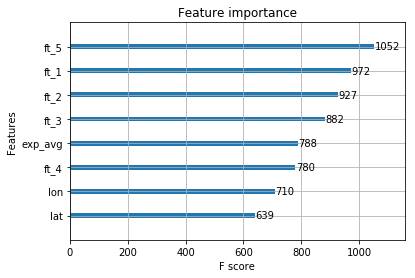

In [414]:
xgb.plot_importance(x_model, importance_type = 'weight')